<h3>Import necessary libraries</h3>

In [60]:
#Import library needed
import pandas as pd
import numpy as np
import nltk
from functools import reduce
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/adikusuma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h3>Read Data Source</h3>

In [8]:
#read
data=pd.read_csv('datasets/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


(-0.5, 399.5, 199.5, -0.5)

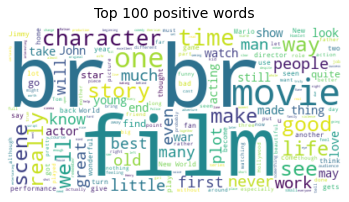

In [65]:
positive_data = data[data['sentiment'] == 'positive']['review'][:100]
positive_data = reduce(lambda a, b : a+b, positive_data)
cloud_positive = WordCloud(background_color='white').generate(positive_data)

plt.imshow(cloud_positive, interpolation='bilinear') 
plt.title('Top 100 positive words', y = 1.02, size = 14) 
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

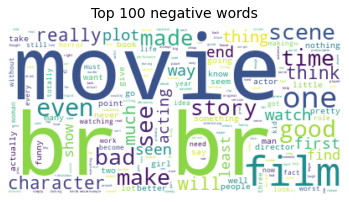

In [67]:
negative_data = data[data['sentiment'] == 'negative']['review'][:100]
negative_data = reduce(lambda a, b : a+b, negative_data)
cloud_negative = WordCloud(background_color='white').generate(negative_data)

plt.imshow(cloud_negative, interpolation='bilinear') 
plt.title('Top 100 negative words', y = 1.02, size = 14) 
plt.axis("off")


In [31]:
print('Number of positive and negative sentiment:\n', data['sentiment'].value_counts())
print('Proportion of positive and negative sentiment:\n', data['sentiment'].value_counts()/len(data))

Number of positive and negative sentiment:
 positive    25000
negative    25000
Name: sentiment, dtype: int64
Proportion of positive and negative sentiment:
 positive    0.5
negative    0.5
Name: sentiment, dtype: float64


In [29]:
length_reviews = data.review.str.len()
print("Longest Review", max(length_reviews))
print("Shortest Review", min(length_reviews))

Longest Review 13704
Shortest Review 32


In [34]:
X = data.drop('review', axis=1)
y = data['sentiment']

In [68]:
word_tokens = [word_tokenize(review) for review in data['review']]
data['n_words'] = [len(word_tokens[i]) for i in range(len(word_tokens))]
data.head()

,review,sentiment,n_words
0,One of the other reviewers has mentioned that ...,positive,380
1,A wonderful little production. <br /><br />The...,positive,201
2,I thought this was a wonderful way to spend ti...,positive,205
3,Basically there's a family where a little boy ...,negative,175
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,283
